# Clustering Penguins
![image](penguins.png)

# Packages used for this project

In [274]:
# Standard
import numpy as np
import pandas as pd

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.api import qqplot
from scipy.cluster.hierarchy import linkage, dendrogram

# Statistics
from scipy.stats import shapiro, kstest, spearmanr
import pingouin

# Utility
import time

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Seed
seed = 64

# Palette for penguin clusters
penguin_colors = ["#28282B", "#FFD700", "#C0C0C0", "#FFAA33"]

# Import data

In [275]:
raw = pd.read_csv("penguins.csv")
raw.head(5)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


# Data information

In [276]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


# Missing values and duplicates

In [277]:
# Missing data
missing = raw.isna().sum()

# Duplicated data
duplicated = raw.duplicated().sum()

# Print results
miss_dup = pd.DataFrame({
    "Missing": missing,
    "Duplicated": duplicated
})

print(miss_dup)

                   Missing  Duplicated
culmen_length_mm         2           1
culmen_depth_mm          2           1
flipper_length_mm        2           1
body_mass_g              2           1
sex                      9           1


# Investigate unique entries for sex

In [278]:
# Unique sex
raw["sex"].unique()

array(['MALE', 'FEMALE', nan, '.'], dtype=object)

# Convert '.' entries to NaN in sex-column

In [279]:
# Convert '.' to NAN
raw["sex"] = raw["sex"].replace(".", np.NAN)

# Drop missing

In [280]:
# Drop missing data
data = raw.dropna(axis=0).copy()

# Print number of missing and duplicated
print(f'Missing: \n{data.isna().sum()}\n\nDuplicated: {data.duplicated().sum()}')

Missing: 
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Duplicated: 0


# Descriptive statistics

In [281]:
# Check descriptive statistics
data.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,334.000000,334.000000,334.000000,334.000000
mean,43.986826,17.173952,214.347305,4207.185629
std,5.461540,1.973277,263.648447,804.009294
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.575000,18.700000,213.000000,4768.750000
max,59.600000,21.500000,5000.000000,6300.000000


# Find outliers

In [282]:
for i in data.select_dtypes(include= "number").columns:
    # Calculate q1 and 13
    q1 = np.quantile(data[i], 0.25)
    q3 = np.quantile(data[i], 0.75)

    # Calculate IQR
    iqr = q3 - q1

    # Lower and upper bound
    lower = iqr - 1.5 * q1
    upper = iqr + 1.5 * q3

    # Find outliers
    outliers = data[
        (data[i] < lower) | 
        (data[i] > upper ) | 
        (data[i] < 0)
        ]
    
    # Print columns with outliers
    print(f'Number of outliers in {i}: {len(outliers)}')

Number of outliers in culmen_length_mm: 0
Number of outliers in culmen_depth_mm: 0
Number of outliers in flipper_length_mm: 2
Number of outliers in body_mass_g: 0


# Remove outliers

In [283]:
# Calculate q1 and 13
q1 = np.quantile(data["flipper_length_mm"], 0.25)
q3 = np.quantile(data["flipper_length_mm"], 0.75)

# Calculate IQR
iqr = q3 - q1

# Lower and upper bound
lower = iqr - 1.5 * q1
upper = iqr + 1.5 * q3

# Remove outliers
penguins = data[~(
    (data["flipper_length_mm"] < lower) | 
    (data["flipper_length_mm"] > upper ) | 
    (data["flipper_length_mm"] < 0)
    )].copy()

# Descriptive data without outliers
penguins.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,332.000000,332.000000,332.000000,332.000000
mean,44.021084,17.153012,200.975904,4206.475904
std,5.452462,1.960275,14.035971,806.361278
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.700000,17.300000,197.000000,4025.000000
75%,48.625000,18.700000,213.000000,4781.250000
max,59.600000,21.500000,231.000000,6300.000000


# Univariate analysis of flipper length (mm)

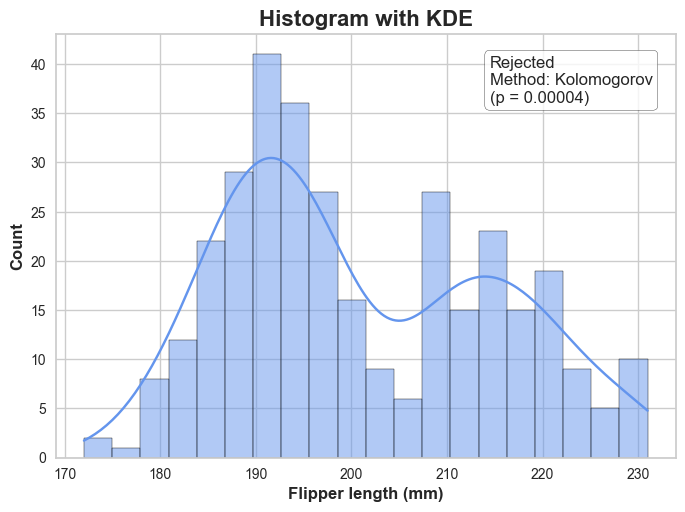

In [284]:
# Test for gaussian distribution
if len(penguins) > 50:
    mean = np.mean(penguins["flipper_length_mm"])
    std = np.std(penguins["flipper_length_mm"])
    ks = kstest(penguins["flipper_length_mm"], "norm", args=(mean, std))

    # Method
    method = "Kolomogorov"

    # p-value
    gauss = ks.pvalue

    # Accept or reject
    if gauss < 0.05:
        distributed = "Rejected"
    else:
        distributed = "Accepted"

else:
    mean = np.mean(penguins["flipper_length_mm"])
    std = np.std(penguins["flipper_length_mm"])
    sw = shapiro(penguins["flipper_length_mm"])

    # Method
    method = "Shapiro"

    # p-value
    gauss = sw.pvalue

    # Accept or reject
    if gauss < 0.05:
        distributed = "Rejected"
    else:
        distributed = "Accepted"

# Histogram of numeric variable
fig, ax = plt.subplots()
sns.histplot(
    data = penguins, 
    x = penguins["flipper_length_mm"], 

    # HIST
    color = "#6495ED",
    alpha = 0.5,
    bins = 20,
    kde=True,
    ax = ax
    )

# Text box
text_hist = f'{distributed}\nMethod: {method}\n(p = {gauss:.5f})'
props_hist = dict(boxstyle='round', facecolor='white', alpha=0.8) 
ax.text(
    0.70, 
    0.95, 
    text_hist, 
    transform=ax.transAxes, 
    fontsize=12,
    verticalalignment='top', 
    bbox=props_hist
    )

# Title
plt.title(
    "Histogram with KDE",
    fontweight = "bold",
    fontsize = 16
)

# Axis labels
plt.xlabel(
    "Flipper length (mm)",
    fontweight = "bold",
    fontsize = 12
)
plt.ylabel(
    "Count",
    fontweight = "bold",
    fontsize = 12
)
plt.show()

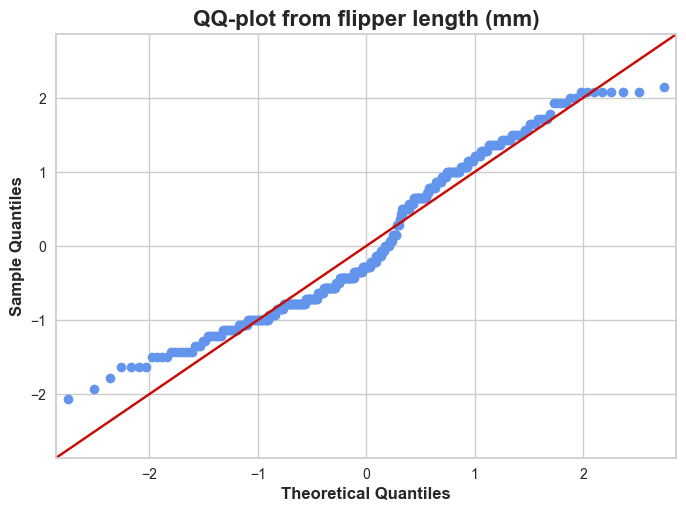

In [285]:
# QQ-plot
fig, ax = plt.subplots()
qqplot(
    # QQ-plot
    penguins["flipper_length_mm"],
    line = "45",
    fit = True,
    markerfacecolor = "#6495ED",
    markeredgecolor = "#6495ED",
    ax = ax
    )

# Title
plt.title(
    "QQ-plot from flipper length (mm)",
    fontweight = "bold",
    fontsize = 16
)

# Axis labels
plt.xlabel(
    "Theoretical Quantiles",
    fontweight = "bold",
    fontsize = 12
)
plt.ylabel(
    "Sample Quantiles",
    fontweight = "bold",
    fontsize = 12
)

plt.show()

Based upon the previous tests and QQ-plot, the flipper length (mm) data does not follow a normal distribution.

# Bivariate analysis

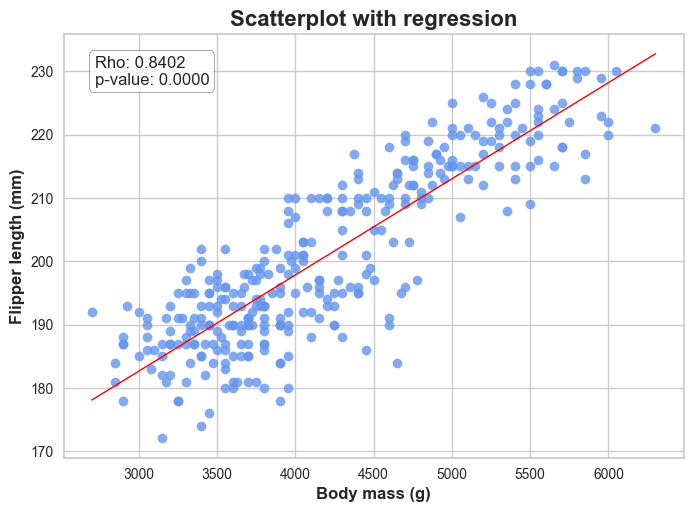

In [286]:
# Scatterplot
fig, ax = plt.subplots()

# Spearman rho
rho, pvalue = spearmanr(penguins["body_mass_g"], penguins["flipper_length_mm"])

# Scatterplot med regression
sns.regplot(
    data = penguins,
    x = "body_mass_g",
    y = "flipper_length_mm",
    color = "#6495ED",
    ci = False,
    line_kws={
        "color": "red",
        "linewidth": 1
        }
)

# Text box
text_scatter = f'Rho: {rho:.4f}\np-value: {pvalue:.4f}'
props_scatter = dict(boxstyle='round', facecolor='white', alpha=0.8) 
ax.text(
    0.05, 
    0.95, 
    text_scatter, 
    transform=ax.transAxes, 
    fontsize=12,
    verticalalignment='top', 
    bbox=props_scatter
    )

# Title
plt.title(
    "Scatterplot with regression",
    fontweight = "bold",
    fontsize = 16
)

# Axis labels
plt.xlabel(
    "Body mass (g)",
    fontweight = "bold",
    fontsize = 12
)
plt.ylabel(
    "Flipper length (mm)",
    fontweight = "bold",
    fontsize = 12
)
plt.show()

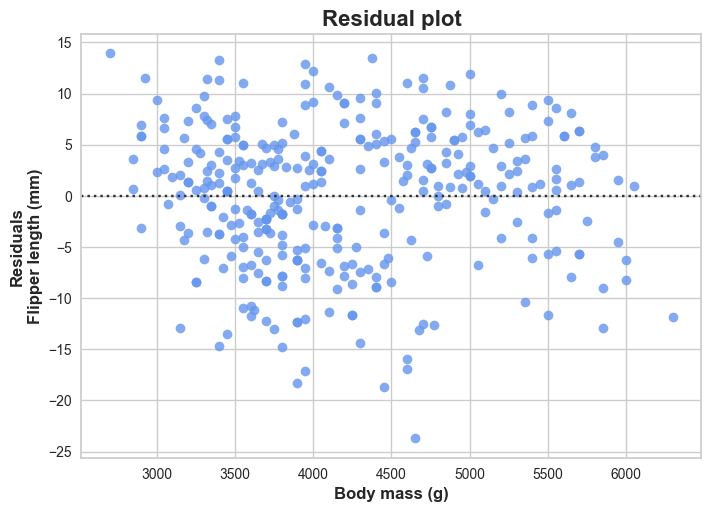

In [287]:
# Residplot
fig, ax = plt.subplots()

# Residual plot
sns.residplot(
    data = penguins,
    x = "body_mass_g",
    y = "flipper_length_mm",
    color = "#6495ED"
)

# Title
plt.title(
    "Residual plot",
    fontweight = "bold",
    fontsize = 16
)

# Axis labels
plt.xlabel(
    "Body mass (g)",
    fontweight = "bold",
    fontsize = 12
)
plt.ylabel(
    "Residuals\nFlipper length (mm)",
    fontweight = "bold",
    fontsize = 12
)
plt.show()

Based upon Spearman's rho (and p-value), as well as visual inspection of the scatter plot and residual plot, I conclude there is a significant positive correlation between body mass (g) and flipper length (mm) in penguins from this dataset.

# Prepare data for clustering

### The univariate analysis of flipper length (mm) from earlier indicated that the flipper length (mm) data is not normal distributed. This deviation may be due to the lack of classification of penguins by species. In the following section, the penguins will be classified by species through data scaling and KMeans clustering.

In [288]:
# Make sex categorical
penguins["sex"] = penguins["sex"].astype("category")

# Get dummies for sex
dummies = pd.get_dummies(penguins)

# Clustering of penguins

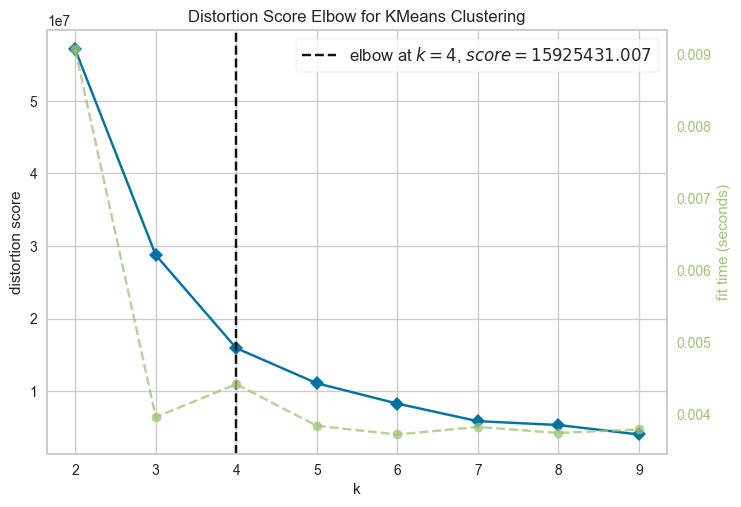

In [289]:
# Instansiate KMeans for KElbowVisualizer
model = KMeans(random_state=seed)

# Visualize optimal number of clusters and update n_clusters in KMeans
num_clusters = 4
show = KElbowVisualizer(model, k=(2, 10))
show.fit(dummies)
show.show()

# Instansiate scaler for clustering
scaler = StandardScaler()

# Instansiate KMeans for clustering 
kmeans = KMeans(n_clusters=num_clusters, random_state=seed)

# Pipeline
pipeline = make_pipeline(
    scaler,
    kmeans
    )

# Fit and predict clusters for dummies data
pipeline.fit(dummies)
penguins["Cluster"] = pipeline.predict(dummies)

Elbow at k = 4 (num_clusters = 4)

# Visualize clustering

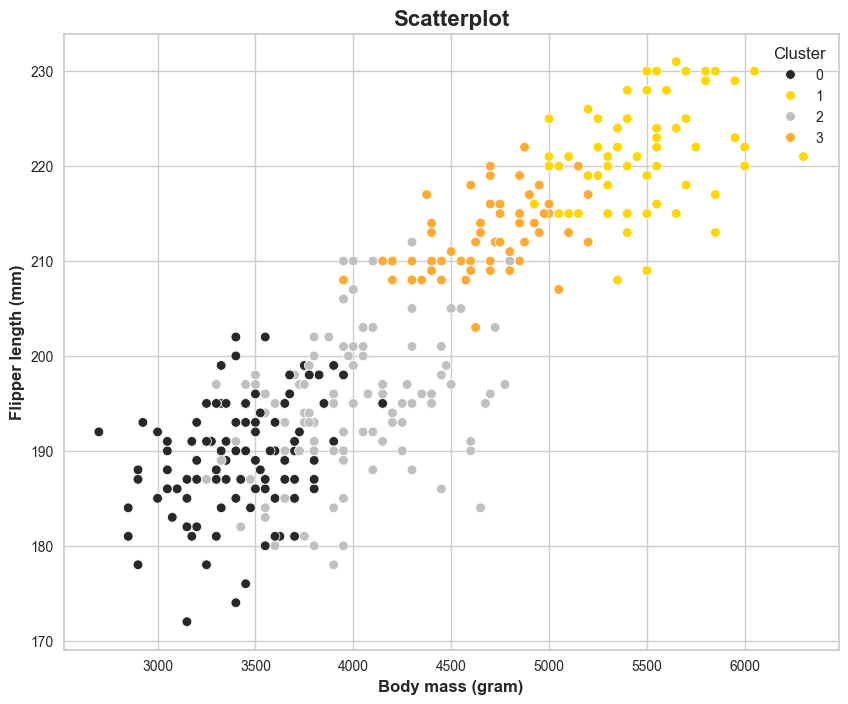

In [290]:
# Scatterplot
fig, ax = plt.subplots(figsize = (10, 8))
sns.scatterplot(
    data = penguins,
    x = "body_mass_g",
    y = "flipper_length_mm",
    hue = "Cluster",
    palette= penguin_colors
)
# Title
plt.title(
    "Scatterplot",
    fontweight = "bold",
    fontsize = 16
)

# Axis labels
plt.xlabel(
    "Body mass (gram)",
    fontweight = "bold",
    fontsize = 12
)
plt.ylabel(
    "Flipper length (mm)",
    fontweight = "bold",
    fontsize = 12
)
plt.show()

# Dendrogram

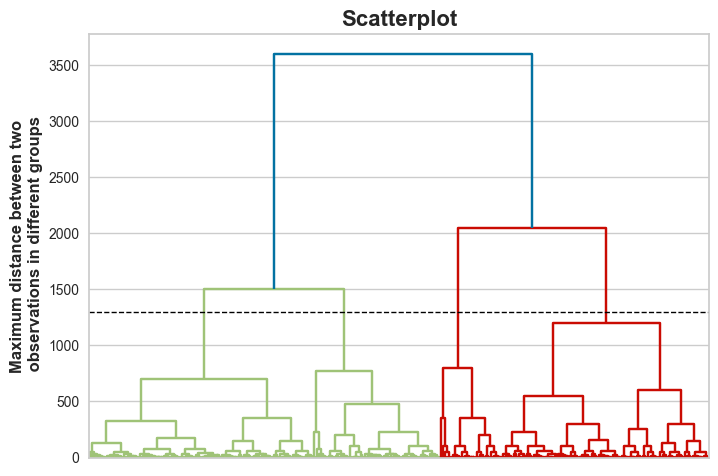

In [342]:
# Linkage 
mergings = linkage(dummies, method = "complete")

# Dendrogram
dendrogram(
    mergings, 
)
# Title
plt.title(
    "Scatterplot",
    fontweight = "bold",
    fontsize = 16
)

# Axis labels
plt.ylabel(
    "Maximum distance between two\n observations in different groups",
    fontweight = "bold",
    fontsize = 12
)

# Remove xticks
plt.xticks(
    []
)

# Cut-off
plt.axhline(y=1300, color='black', linestyle='--', linewidth = 1)
plt.show()

# Univariate analysis for each cluster

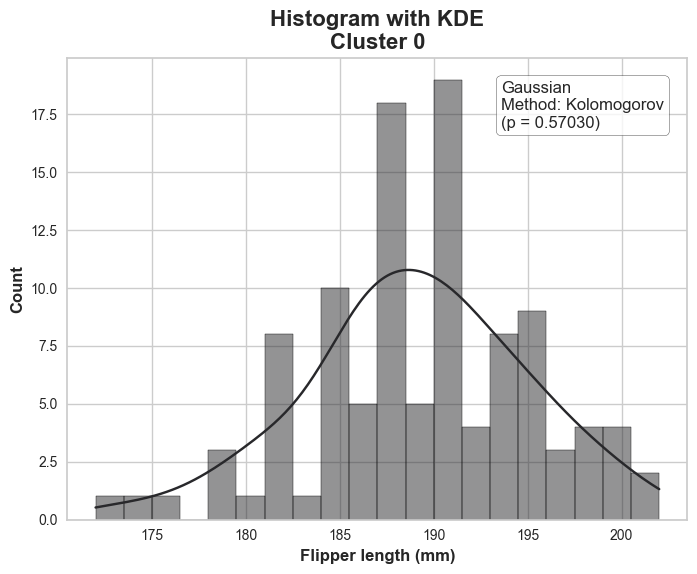

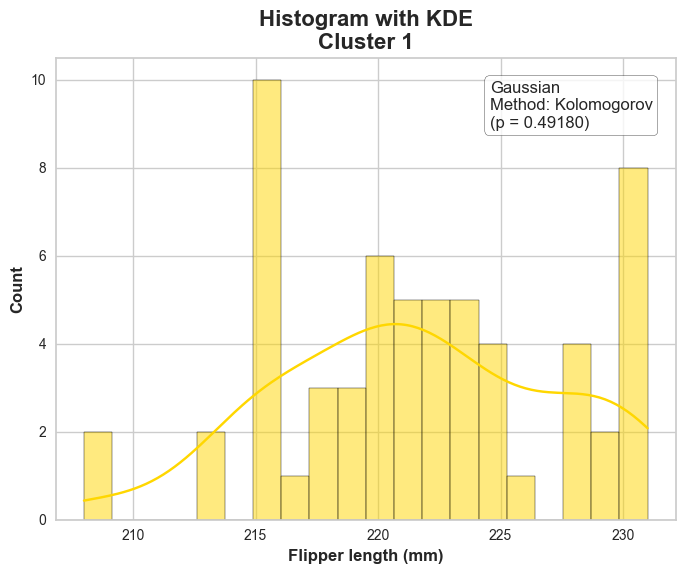

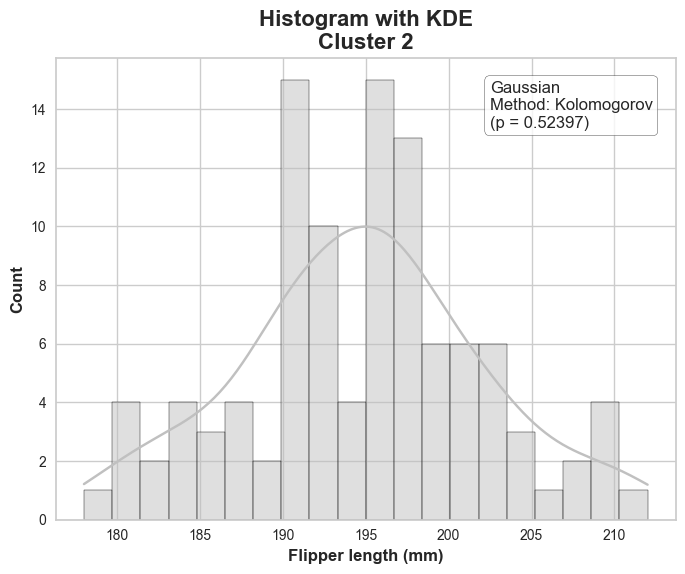

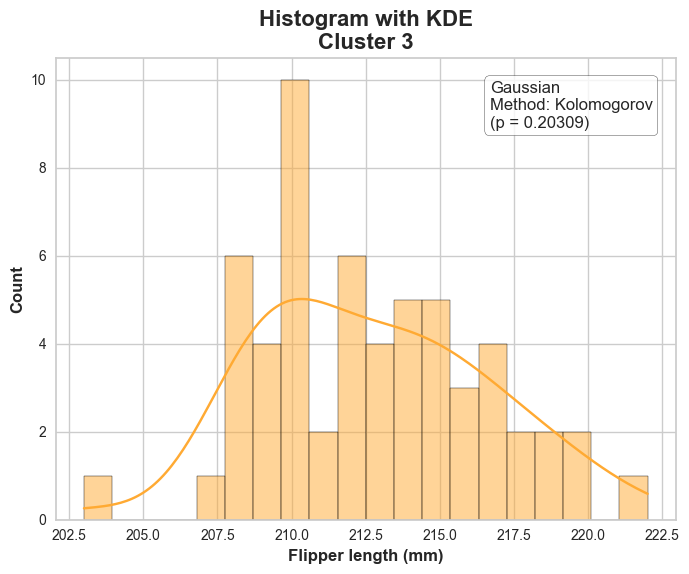

In [291]:
# Test for gaussian distribution
for i in range(num_clusters):
    if len(penguins[penguins["Cluster"] == i]) > 50:    # Kolmogorov-Smirnov
        mean = np.mean(penguins[penguins["Cluster"] == i]["flipper_length_mm"])
        std = np.std(penguins[penguins["Cluster"] == i]["flipper_length_mm"])
        ks = kstest(penguins[penguins["Cluster"] == i]["flipper_length_mm"], "norm", args=(mean, std))

        # Method
        method = "Kolomogorov"

        # p-value
        gauss = ks.pvalue

        # Accept or reject
        if gauss < 0.05:
            distributed = "Not gaussian"
        else:
            distributed = "Gaussian"
        
    else:   # Shapiro Wilk Test
        mean = np.mean(penguins[penguins["Cluster"] == i]["flipper_length_mm"])
        std = np.std(penguins[penguins["Cluster"] == i]["flipper_length_mm"])
        sw = shapiro(penguins[penguins["Cluster"] == i]["flipper_length_mm"])

        # Method
        method = "Shapiro"

        # p-value
        gauss = sw.pvalue

        # Accept or reject
        if gauss < 0.05:
            distributed = "Not gaussian"
        else:
            distributed = "Gaussian"

    # Histogram of numeric variable
    fig, ax = plt.subplots(figsize = (8, 6))
    sns.histplot(
        data = penguins, 
        x = penguins[penguins["Cluster"] == i]["flipper_length_mm"], 

        # HIST
        color = penguin_colors[i],
        alpha = 0.5,
        bins = 20,
        kde=True,
        ax = ax
        )

    # Text box
    cluster_text = f'{distributed}\nMethod: {method}\n(p = {gauss:.5f})'
    cluster_props = dict(boxstyle='round', facecolor='white', alpha=0.8) 
    ax.text(
        0.70, 
        0.95, 
        cluster_text, 
        transform=ax.transAxes, 
        fontsize=12,
        verticalalignment='top', 
        bbox=cluster_props
    )

    # Title
    plt.title(
        f'Histogram with KDE\nCluster {i}',
        fontweight = "bold",
        fontsize = 16
    )

    # Axis labels
    plt.xlabel(
        "Flipper length (mm)",
        fontweight = "bold",
        fontsize = 12
    )
    plt.ylabel(
        "Count",
        fontweight = "bold",
        fontsize = 12
    )
    plt.show()

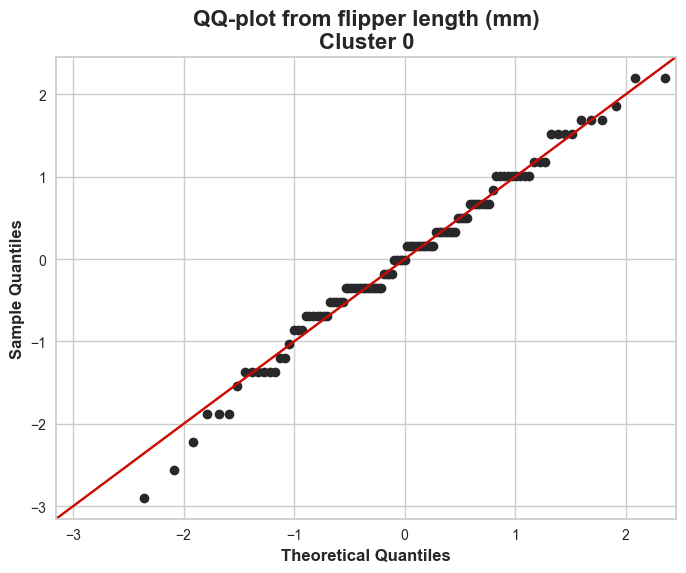

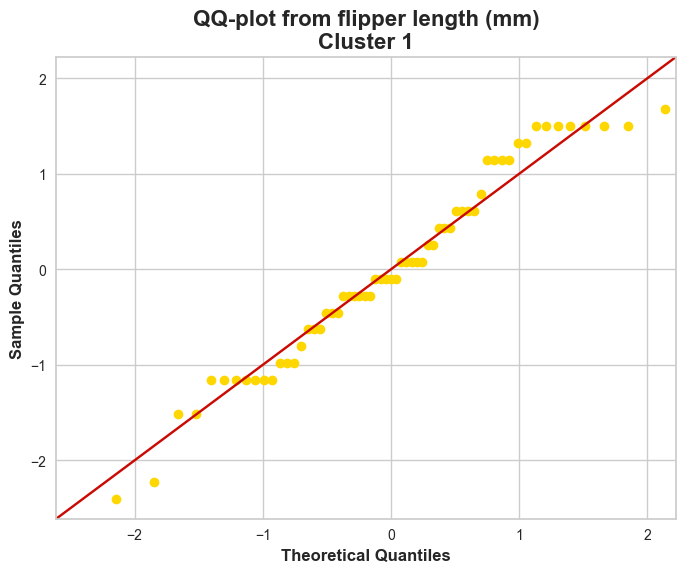

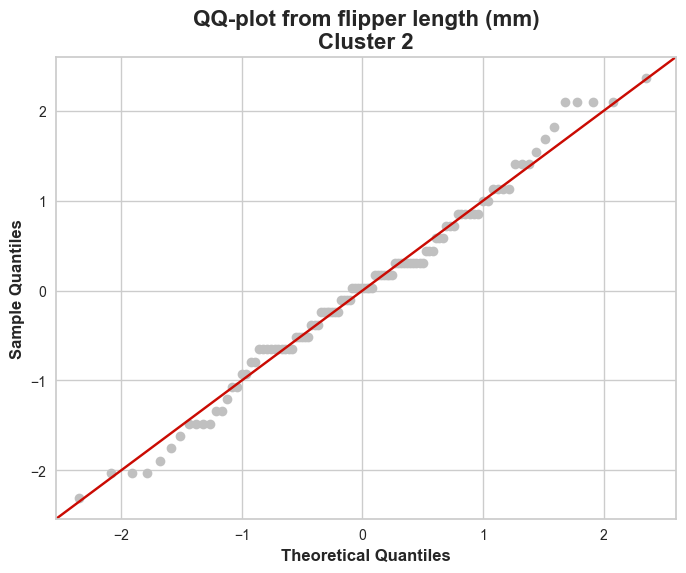

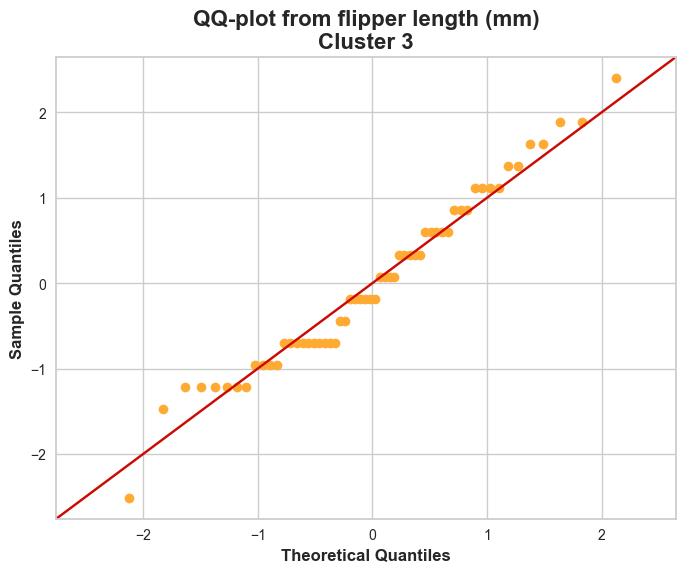

In [292]:
# QQ-plot
for i in range(num_clusters):
    fig, ax = plt.subplots(figsize = (8, 6))
    qqplot(
        penguins[penguins["Cluster"] == i]["flipper_length_mm"],
        line = "45",
        fit = True,
        markerfacecolor = penguin_colors[i],
        markeredgecolor = penguin_colors[i],
        ax = ax,
        )
    
    # Title
    plt.title(
        f'QQ-plot from flipper length (mm)\nCluster {i}',
        fontweight = "bold",
        fontsize = 16
    )

    # Axis labels
    plt.xlabel(
        "Theoretical Quantiles",
        fontweight = "bold",
        fontsize = 12
    )
    plt.ylabel(
        "Sample Quantiles",
        fontweight = "bold",
        fontsize = 12
    )
    plt.show()

# Do all penguin species (clusters) weigh the same?

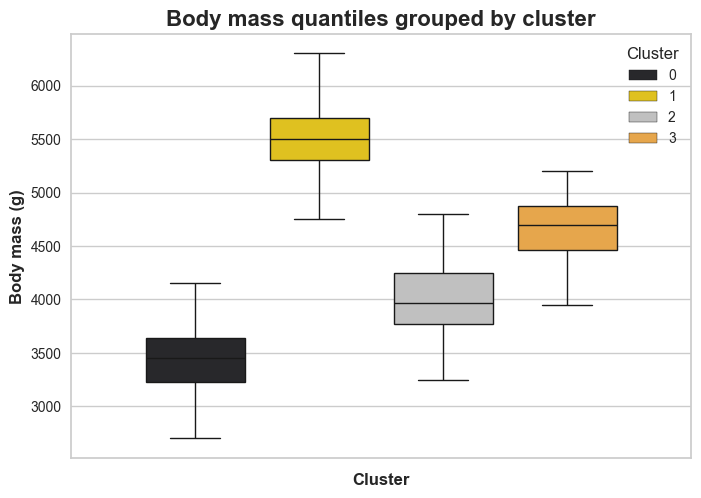

In [293]:
# Histogram
fig, ax = plt.subplots()
sns.boxplot(
    data = penguins,
    y = penguins["body_mass_g"],
    hue = penguins["Cluster"],
    palette=penguin_colors,
    width=0.8,
    dodge=True,
    gap = 0.2
)

# Title
plt.title(
    "Body mass quantiles grouped by cluster",
    fontweight = "bold",
    fontsize = 16
)

# Axis labels
plt.xlabel(
    "Cluster",
    fontweight = "bold",
    fontsize = 12
    )
plt.ylabel(
    "Body mass (g)",
    fontweight = "bold",
    fontsize = 12
    )

plt.show()

# Anova and post-hoc tests

In [294]:
# One-way ANOVA
penguins_anova = pingouin.anova(
    data = penguins,
    dv = "body_mass_g",
    between= "Cluster",
    detailed=True
)
print(penguins_anova)

# Post-hoc test
penguins_posthoc = pingouin.pairwise_tukey(
    data = penguins,
    dv = "body_mass_g",
    between= "Cluster"
)
print(penguins_posthoc)

    Source            SS   DF            MS           F          p-unc  \
0  Cluster  1.832378e+08    3  6.107927e+07  626.365485  2.201793e-135   
1   Within  3.198452e+07  328  9.751378e+04         NaN            NaN   

        np2  
0  0.851388  
1       NaN  
   A  B      mean(A)      mean(B)         diff         se          T  \
0  0  1  3419.158879  5484.836066 -2065.677187  50.099206 -41.231735   
1  0  2  3419.158879  4006.603774  -587.444895  42.793517 -13.727427   
2  0  3  3419.158879  4679.741379 -1260.582501  50.917737 -24.757237   
3  1  2  5484.836066  4006.603774  1478.232292  50.184938  29.455696   
4  1  3  5484.836066  4679.741379   805.094686  57.270051  14.057866   
5  2  3  4006.603774  4679.741379  -673.137606  51.002093 -13.198235   

        p-tukey    hedges  
0  1.265654e-14 -6.987276  
1  1.265654e-14 -1.830304  
2  1.265654e-14 -4.440971  
3  1.265654e-14  4.339571  
4  1.265654e-14  2.682582  
5  1.265654e-14 -2.032347  
